In [1]:
import numpy as np
import pandas as pd
import dataframe_image as dfi

In [2]:
df = pd.read_excel('Datasets_Ready.xlsx')

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4510 entries, 0 to 4509
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      4510 non-null   int64  
 1   Text            4510 non-null   object 
 2   emoji           4510 non-null   object 
 3   Tokenized       4510 non-null   object 
 4   final_text      4494 non-null   object 
 5   text_emoji      4510 non-null   object 
 6   Pos_Word        4510 non-null   int64  
 7   Neg_Word        4510 non-null   int64  
 8   Total_Word      4510 non-null   int64  
 9   Pos_Ratio       4510 non-null   float64
 10  Neg_Ratio       4510 non-null   float64
 11  Sentimen_Text   4510 non-null   object 
 12  Tokenize_Emoji  4510 non-null   object 
 13  Pos_Emoji       4510 non-null   int64  
 14  Neg_Emoji       4510 non-null   int64  
 15  Sentimen_Emoji  4510 non-null   object 
 16  Sarcasm         4510 non-null   object 
dtypes: float64(2), int64(6), object(9

,Unnamed: 0,Text,emoji,Tokenized,final_text,text_emoji,Pos_Word,Neg_Word,Total_Word,Pos_Ratio,Neg_Ratio,Sentimen_Text,Tokenize_Emoji,Pos_Emoji,Neg_Emoji,Sentimen_Emoji,Sarcasm
0,0,kawan2 sunda bersatu jemput arteria dahlan,😁,"['kawan', 'sunda', 'bersatu', 'jemput', 'arter...",kawan sunda bersatu jemput arteria dahlan,kawan sunda bersatu jemput arteria dahlan 😁,2,0,6,0.333333,0.000000,Positif,"['kawan', 'sunda', 'bersatu', 'jemput', 'arter...",1,0,Positif,Negatif
1,2,arteria dahlan disidang adat sunda daerah menu...,😁,"['arteria', 'dahlan', 'sidang', 'adat', 'sunda...",arteria dahlan sidang adat sunda daerah menunt...,arteria dahlan sidang adat sunda daerah menunt...,5,4,9,0.555556,0.444444,Positif,"['arteria', 'dahlan', 'sidang', 'adat', 'sunda...",1,0,Positif,Negatif
2,4,ga ditafsirkan membanding bandingkan edy arter...,😁,"['ga', 'tafsir', 'membanding', 'membandingkan'...",ga tafsir membanding membandingkan edy arteria...,ga tafsir membanding membandingkan edy arteria...,3,2,9,0.333333,0.222222,Positif,"['ga', 'tafsir', 'membanding', 'membandingkan'...",1,0,Positif,Negatif
3,5,nantik ngak divhumas polri nya bilang palsu td...,😁,"['nanti', 'tidak', 'divisi humas', 'polri', '....",divisi humas polri bilang palsu mengeluarkan a...,divisi humas polri bilang palsu mengeluarkan a...,4,8,16,0.250000,0.500000,Negatif,"['divisi', 'humas', 'polri', 'bilang', 'palsu'...",1,0,Positif,Positif
4,6,urut dada dech kuasa hukum tdk mengerti hukum ...,😁,"['urut', 'dada', 'deh', 'kuasa', 'hukum', 'tid...",urut dada deh kuasa hukum mengerti hukum arter...,urut dada deh kuasa hukum mengerti hukum arter...,14,6,28,0.500000,0.214286,Positif,"['urut', 'dada', 'deh', 'kuasa', 'hukum', 'men...",1,0,Positif,Negatif


In [3]:
# Remove unused column/feature
df = df.drop(columns='Unnamed: 0')
df = df.drop(columns='Text')
df = df.drop(columns='emoji')
df = df.drop(columns='Tokenized')
df = df.drop(columns='final_text')
df = df.drop(columns='Pos_Word')
df = df.drop(columns='Neg_Word')
df = df.drop(columns='Total_Word')
df = df.drop(columns='Pos_Ratio')
df = df.drop(columns='Neg_Ratio')
df = df.drop(columns='Tokenize_Emoji')
df = df.drop(columns='Pos_Emoji')
df = df.drop(columns='Neg_Emoji')
df = df.drop(columns='Sentimen_Emoji')

In [4]:
df.head()

,text_emoji,Sentimen_Text,Sarcasm
0,kawan sunda bersatu jemput arteria dahlan 😁,Positif,Negatif
1,arteria dahlan sidang adat sunda daerah menunt...,Positif,Negatif
2,ga tafsir membanding membandingkan edy arteria...,Positif,Negatif
3,divisi humas polri bilang palsu mengeluarkan a...,Negatif,Positif
4,urut dada deh kuasa hukum mengerti hukum arter...,Positif,Negatif


In [5]:
df_ready = df[:20]

In [6]:
df_ready.info()
df_ready.head(21)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text_emoji     20 non-null     object
 1   Sentimen_Text  20 non-null     object
 2   Sarcasm        20 non-null     object
dtypes: object(3)
memory usage: 608.0+ bytes


,text_emoji,Sentimen_Text,Sarcasm
0,kawan sunda bersatu jemput arteria dahlan 😁,Positif,Negatif
1,arteria dahlan sidang adat sunda daerah menunt...,Positif,Negatif
2,ga tafsir membanding membandingkan edy arteria...,Positif,Negatif
3,divisi humas polri bilang palsu mengeluarkan a...,Negatif,Positif
4,urut dada deh kuasa hukum mengerti hukum arter...,Positif,Negatif
5,arteria dahlan maaf memaafkan kubu maaf saran ...,Positif,Negatif
6,dorong masyarakat sunda jabar polri menangkap ...,Positif,Negatif
7,beruntung arteria dahlan ga kabar e hina suku ...,Positif,Negatif
8,pejabat sakit jiwa menantang goblok pejabat ra...,Negatif,Positif
9,pasteur bandung arteria dahlan mulut busuk 😁,Negatif,Positif


<h1>Feature Extraction Using GloVe Method</h1>

In [7]:
class GloVe:
    # constructors
    def __init__(self, corpus, embedding_size=100, window_size=5):
        self.corpus = corpus
        self.embedding_size = embedding_size
        self.window_size = window_size
        self.word2id = {}
        self.id2word = {}
        self.word2count = {}
        self.vocab_size = 0
        self.co_matrix = None
        self.embedding = None
        self.bias = None

    def build_vocab_information(self):
        for sentence in self.corpus:
            for word in sentence.split():
                if word not in self.word2id:
                    self.word2id[word] = self.vocab_size
                    self.id2word[self.vocab_size] = word
                    self.vocab_size += 1
                self.word2count[word] = self.word2count.get(word, 0) + 1

    def build_co_matrix(self):
        self.co_matrix = np.zeros((self.vocab_size, self.vocab_size))
        for sentence in self.corpus:
            sentence = sentence.split()
            for i, center_word in enumerate(sentence):
                for j in range(max(0, i - self.window_size), i):
                    context_word = sentence[j]
                    self.co_matrix[self.word2id[center_word]][self.word2id[context_word]] += 1
                    self.co_matrix[self.word2id[context_word]][self.word2id[center_word]] += 1

    def train(self, num_epochs=5000, learning_rate=0.01):
        self.embedding = (np.random.rand(self.vocab_size, self.embedding_size) - 0.5) / self.embedding_size
        self.bias = np.zeros(self.vocab_size)

        for epoch in range(num_epochs):
            loss = 0
            for i in range(self.vocab_size):
                for j in range(self.vocab_size):
                    if self.co_matrix[i][j] != 0:
                        diff = (self.embedding[i] @ self.embedding[j]) + self.bias[i] + self.bias[j] - np.log(self.co_matrix[i][j])
                        loss += diff ** 2

                        grad_emb_i = diff * self.embedding[j]
                        grad_emb_j = diff * self.embedding[i]
                        grad_bias_i = diff
                        grad_bias_j = diff

                        self.embedding[i] -= learning_rate * grad_emb_i
                        self.embedding[j] -= learning_rate * grad_emb_j
                        self.bias[i] -= learning_rate * grad_bias_i
                        self.bias[j] -= learning_rate * grad_bias_j

            print(f'Epoch {epoch + 1}/{num_epochs} - loss {round(loss, 3)}')
            
            if loss <= 0.001:
                print('Training Stopped, loss less than equal 0.001')
                break

    def get_all_embeddings(self):
        all_embeddings = {}
        for word, word_id in self.word2id.items():
            all_embeddings[word] = self.embedding[word_id]
        return all_embeddings
    
    def get_embeddings_by_id(self, id):
        return self.embedding[id]
    
    def get_embeddings(self, kata):
        word_embeddings = {}
        for word, word_id in self.word2id.items():
            if word == kata:
                word_embeddings[word] = self.embedding[word_id]
        return word_embeddings

    def embedding2word(self):
        embedding_to_word = {}
        for word, word_id in self.word2id.items():
            embedding_to_word[tuple(self.embedding[word_id])] = word
        return embedding_to_word
    
    def get_glove_embedding(self, sentence):
        sentence = sentence.split()
        embedding_vectors = []
        for word in sentence:
            if word in self.word2id:
                word_id = self.word2id[word]
                word_embedding = self.embedding[word_id]
                embedding_vectors.append(word_embedding)
        return embedding_vectors
    
    def show_comatrix(self):
        # df_co_matrix = pd.DataFrame(self.co_matrix, index=self.word2id.keys(), columns=self.word2id.keys())
        
        return self.co_matrix
    
    def generate_coomatrix_image(self):
        df_co_matrix = pd.DataFrame(self.co_matrix, index=self.word2id.keys(), columns=self.word2id.keys())

        print('Image is being processed...')
        dfi.export(df_co_matrix.head(10), "coocurrenceMatrix.png", max_cols=10)
        
        return print('Coocurrence matrix has been successfully generated into an image')
    
    def show_word2id(self):
        return self.word2id
    
    def show_id2word(self):
        return self.id2word
    
    def show_word2count(self):
        return self.word2count

In [8]:
# Membangun model GloVe
glove_model = GloVe(df_ready['text_emoji'])

# Membangun vocabulary
glove_model.build_vocab_information()

# Membangun co-occurrence matrix
glove_model.build_co_matrix()

# Melatih model GloVe
glove_model.train()

Epoch 1/5000 - loss 175.346
Epoch 2/5000 - loss 147.93
Epoch 3/5000 - loss 136.984
Epoch 4/5000 - loss 130.96
Epoch 5/5000 - loss 127.333
Epoch 6/5000 - loss 125.032
Epoch 7/5000 - loss 123.51
Epoch 8/5000 - loss 122.466
Epoch 9/5000 - loss 121.722
Epoch 10/5000 - loss 121.169
Epoch 11/5000 - loss 120.735
Epoch 12/5000 - loss 120.373
Epoch 13/5000 - loss 120.045
Epoch 14/5000 - loss 119.725
Epoch 15/5000 - loss 119.384
Epoch 16/5000 - loss 118.997
Epoch 17/5000 - loss 118.534
Epoch 18/5000 - loss 117.965
Epoch 19/5000 - loss 117.248
Epoch 20/5000 - loss 116.338
Epoch 21/5000 - loss 115.179
Epoch 22/5000 - loss 113.707
Epoch 23/5000 - loss 111.851
Epoch 24/5000 - loss 109.537
Epoch 25/5000 - loss 106.701
Epoch 26/5000 - loss 103.294
Epoch 27/5000 - loss 99.31
Epoch 28/5000 - loss 94.8
Epoch 29/5000 - loss 89.887
Epoch 30/5000 - loss 84.766
Epoch 31/5000 - loss 79.683
Epoch 32/5000 - loss 74.895
Epoch 33/5000 - loss 70.614
Epoch 34/5000 - loss 66.973
Epoch 35/5000 - loss 64.008
Epoch 36/

In [9]:
# Menampilkan Dict word2id
word_2_id = glove_model.show_word2id()
word_2_id

{'kawan': 0,
 'sunda': 1,
 'bersatu': 2,
 'jemput': 3,
 'arteria': 4,
 'dahlan': 5,
 '😁': 6,
 'sidang': 7,
 'adat': 8,
 'daerah': 9,
 'menuntut': 10,
 'hukum': 11,
 'ga': 12,
 'tafsir': 13,
 'membanding': 14,
 'membandingkan': 15,
 'edy': 16,
 'menegakkan': 17,
 'divisi': 18,
 'humas': 19,
 'polri': 20,
 'bilang': 21,
 'palsu': 22,
 'mengeluarkan': 23,
 'membenarkan': 24,
 'plat': 25,
 'no': 26,
 'asli': 27,
 'urut': 28,
 'dada': 29,
 'deh': 30,
 'kuasa': 31,
 'mengerti': 32,
 'tsb': 33,
 'dengar': 34,
 'pendapat': 35,
 'gedung': 36,
 'dpr': 37,
 'memiliki': 38,
 'kekebalan': 39,
 'atur': 40,
 'konstitusi': 41,
 'n': 42,
 'uu': 43,
 'maaf': 44,
 'memaafkan': 45,
 'kubu': 46,
 'saran': 47,
 'dorong': 48,
 'masyarakat': 49,
 'jabar': 50,
 'menangkap': 51,
 'semoga': 52,
 'berpegang': 53,
 'komitmen': 54,
 'menenggelamkan': 55,
 'partai': 56,
 'demokrasi': 57,
 'indonesia': 58,
 'perjuangan': 59,
 'spt': 60,
 'sumbar': 61,
 'beruntung': 62,
 'kabar': 63,
 'e': 64,
 'hina': 65,
 'suku': 66

In [10]:
# Menampilkan Dict id2word
id_2_word = glove_model.show_id2word()
id_2_word

{0: 'kawan',
 1: 'sunda',
 2: 'bersatu',
 3: 'jemput',
 4: 'arteria',
 5: 'dahlan',
 6: '😁',
 7: 'sidang',
 8: 'adat',
 9: 'daerah',
 10: 'menuntut',
 11: 'hukum',
 12: 'ga',
 13: 'tafsir',
 14: 'membanding',
 15: 'membandingkan',
 16: 'edy',
 17: 'menegakkan',
 18: 'divisi',
 19: 'humas',
 20: 'polri',
 21: 'bilang',
 22: 'palsu',
 23: 'mengeluarkan',
 24: 'membenarkan',
 25: 'plat',
 26: 'no',
 27: 'asli',
 28: 'urut',
 29: 'dada',
 30: 'deh',
 31: 'kuasa',
 32: 'mengerti',
 33: 'tsb',
 34: 'dengar',
 35: 'pendapat',
 36: 'gedung',
 37: 'dpr',
 38: 'memiliki',
 39: 'kekebalan',
 40: 'atur',
 41: 'konstitusi',
 42: 'n',
 43: 'uu',
 44: 'maaf',
 45: 'memaafkan',
 46: 'kubu',
 47: 'saran',
 48: 'dorong',
 49: 'masyarakat',
 50: 'jabar',
 51: 'menangkap',
 52: 'semoga',
 53: 'berpegang',
 54: 'komitmen',
 55: 'menenggelamkan',
 56: 'partai',
 57: 'demokrasi',
 58: 'indonesia',
 59: 'perjuangan',
 60: 'spt',
 61: 'sumbar',
 62: 'beruntung',
 63: 'kabar',
 64: 'e',
 65: 'hina',
 66: 'suku'

In [11]:
# Menampilkan Dict word2count
word_2_count = glove_model.show_word2count()
word_2_count

{'kawan': 1,
 'sunda': 9,
 'bersatu': 1,
 'jemput': 1,
 'arteria': 20,
 'dahlan': 19,
 '😁': 20,
 'sidang': 1,
 'adat': 2,
 'daerah': 1,
 'menuntut': 1,
 'hukum': 5,
 'ga': 2,
 'tafsir': 1,
 'membanding': 1,
 'membandingkan': 1,
 'edy': 1,
 'menegakkan': 1,
 'divisi': 1,
 'humas': 1,
 'polri': 2,
 'bilang': 1,
 'palsu': 1,
 'mengeluarkan': 1,
 'membenarkan': 1,
 'plat': 2,
 'no': 1,
 'asli': 1,
 'urut': 1,
 'dada': 1,
 'deh': 1,
 'kuasa': 1,
 'mengerti': 1,
 'tsb': 2,
 'dengar': 1,
 'pendapat': 1,
 'gedung': 1,
 'dpr': 1,
 'memiliki': 1,
 'kekebalan': 1,
 'atur': 1,
 'konstitusi': 1,
 'n': 1,
 'uu': 1,
 'maaf': 3,
 'memaafkan': 2,
 'kubu': 1,
 'saran': 1,
 'dorong': 1,
 'masyarakat': 3,
 'jabar': 3,
 'menangkap': 1,
 'semoga': 1,
 'berpegang': 1,
 'komitmen': 1,
 'menenggelamkan': 1,
 'partai': 2,
 'demokrasi': 2,
 'indonesia': 3,
 'perjuangan': 2,
 'spt': 1,
 'sumbar': 1,
 'beruntung': 1,
 'kabar': 1,
 'e': 1,
 'hina': 1,
 'suku': 1,
 'pejabat': 3,
 'sakit': 1,
 'jiwa': 1,
 'menantang'

In [12]:
# Menampilkan hasil dari Cooccurence Matrix
co_matrix = glove_model.show_comatrix()

co_matrix

array([[0., 1., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 1., 1., 1.],
       [1., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 1., 0., 1.],
       [0., 1., 0., ..., 0., 1., 0.]])

In [13]:
# # Generate image Matrix Coocurrence
# generateCooMatrix = glove_model.generate_coomatrix_image()

# generateCooMatrix

In [14]:
word_embeddings = glove_model.get_embeddings('😁')

print(word_embeddings)

{'😁': array([ 7.24957448e-02,  9.53783209e-01, -4.09050597e-01,  1.77237312e-01,
        2.37206118e-01, -4.88395333e-01,  1.34882968e-03, -1.13326757e+00,
       -4.11653196e-01,  1.05409728e-01,  1.04158620e+00,  3.82327167e-01,
       -1.56067419e+00,  4.65869469e-01,  4.36148636e-01,  6.28375279e-01,
       -4.73243454e-01,  5.86403279e-01, -6.14218763e-01,  2.28078627e-01,
       -3.43711172e-01, -3.75762226e-01,  8.70262686e-02, -2.80372236e-01,
        1.42317499e-01,  5.73960627e-01,  4.08987714e-01,  1.77085279e-01,
       -2.46221349e-01, -4.06089672e-02, -4.84028336e-01, -2.19962557e-01,
       -1.75727231e-01, -5.52019271e-01, -5.07178015e-01, -4.27437506e-01,
       -5.68385668e-01, -1.02690036e-01, -4.53742509e-01,  1.36830491e-01,
        3.28259510e-01,  6.67609305e-01,  3.42801542e-01,  1.57302329e-01,
       -6.48682897e-01, -5.49523931e-01, -1.29954271e-01, -6.98491006e-01,
        5.17226911e-01,  9.81707843e-01,  2.62316668e-02,  1.15557431e-01,
        7.86103104e

In [15]:
embedding_by_id = glove_model.get_embeddings_by_id(6)

embedding_by_id

array([ 7.24957448e-02,  9.53783209e-01, -4.09050597e-01,  1.77237312e-01,
        2.37206118e-01, -4.88395333e-01,  1.34882968e-03, -1.13326757e+00,
       -4.11653196e-01,  1.05409728e-01,  1.04158620e+00,  3.82327167e-01,
       -1.56067419e+00,  4.65869469e-01,  4.36148636e-01,  6.28375279e-01,
       -4.73243454e-01,  5.86403279e-01, -6.14218763e-01,  2.28078627e-01,
       -3.43711172e-01, -3.75762226e-01,  8.70262686e-02, -2.80372236e-01,
        1.42317499e-01,  5.73960627e-01,  4.08987714e-01,  1.77085279e-01,
       -2.46221349e-01, -4.06089672e-02, -4.84028336e-01, -2.19962557e-01,
       -1.75727231e-01, -5.52019271e-01, -5.07178015e-01, -4.27437506e-01,
       -5.68385668e-01, -1.02690036e-01, -4.53742509e-01,  1.36830491e-01,
        3.28259510e-01,  6.67609305e-01,  3.42801542e-01,  1.57302329e-01,
       -6.48682897e-01, -5.49523931e-01, -1.29954271e-01, -6.98491006e-01,
        5.17226911e-01,  9.81707843e-01,  2.62316668e-02,  1.15557431e-01,
        7.86103104e-01,  

In [16]:
all_embedding = glove_model.get_all_embeddings()

all_embedding

{'kawan': array([-0.03557466, -0.01219717,  0.0077784 , -0.00794055,  0.02397475,
         0.0274791 , -0.00721958,  0.00509582, -0.00082825,  0.01180984,
         0.0012978 , -0.01173431, -0.00525735, -0.00518638,  0.00276578,
        -0.00635087,  0.00765102, -0.0290703 , -0.01262139, -0.02295832,
        -0.02106148, -0.00170306, -0.02929693,  0.00523942, -0.02257971,
         0.01429833, -0.0018897 , -0.03818366, -0.00033124,  0.03050145,
        -0.00395174, -0.02373819, -0.00459242,  0.01320374, -0.03337644,
         0.01308543,  0.03280471, -0.00357741,  0.03152612, -0.01256804,
         0.0090076 ,  0.01894877, -0.04806061,  0.00322753, -0.03958273,
         0.0108069 , -0.00784382,  0.03255541, -0.01276415, -0.01208481,
        -0.00440544, -0.01479758,  0.00332948, -0.00680155, -0.00682115,
        -0.00771602,  0.00651339,  0.00546527,  0.0293026 , -0.00312863,
        -0.01691392,  0.0196061 , -0.01240254, -0.02071847, -0.01172465,
         0.01327182,  0.00993605, -0.00119

In [17]:
# # Mendapatkan semua embedding
# embeddings = glove_model.get_embeddings()

# # Menyimpan embedding ke file teks
# output_file = "embeddings.txt"
# with open(output_file, "w", encoding="utf-8") as file:
#     for word, embedding in embeddings.items():
#         embedding_line = "{} {}\n".format(word, " ".join(str(value) for value in embedding))
#         file.write(embedding_line)

# print("Embedding telah disimpan ke file: {}".format(output_file))

<h1>Create New Feature for Word Embeddings</h1>

In [18]:
# df_ready['embedding'] = df_ready['text_emoji'].apply(lambda x: glove_model.get_glove_embedding(x))

In [19]:
# df_ready.head()

<h2>Fungsi untuk merubah token menjadi representasi word embedding</h2>

In [20]:
# def replace_token_with_word_embedding(token, word_embedding):
#     embeddings = []
#     for word in token:
#         if word in word_embedding:
#             embeddings.append(word_embedding[word])
    
#     return np.array(embeddings)

In [21]:
# df_ready['text_emoji'] = df_ready['text_emoji'].apply(replace_token_with_word_embedding, word_embedding=word_embeddings)

In [22]:
# df_ready.head()

In [23]:
# df_ready['text_emoji'].duplicated().sum()

In [24]:
# df_ready.head()

In [25]:
# df_ready['text_emoji'][0]

In [26]:
# embedding2word = glove_model.embedding2word()

# embedding2word[tuple(df_ready['text_emoji'][0][0])]

<h1>Implement SMOTE</h1>

In [27]:
df_ready['Sentimen_Text'] = df_ready['Sentimen_Text'].replace('Positif', 1)
df_ready['Sentimen_Text'] = df_ready['Sentimen_Text'].replace('Negatif', 0)

df_ready['Sarcasm'] = df_ready['Sarcasm'].replace('Positif', 1)
df_ready['Sarcasm'] = df_ready['Sarcasm'].replace('Negatif', 0)

C:\Users\DELL\AppData\Local\Temp\ipykernel_21568\3562434511.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ready['Sentimen_Text'] = df_ready['Sentimen_Text'].replace('Positif', 1)
C:\Users\DELL\AppData\Local\Temp\ipykernel_21568\3562434511.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ready['Sentimen_Text'] = df_ready['Sentimen_Text'].replace('Negatif', 0)
C:\Users\DELL\AppData\Local\Temp\ipykernel_21568\3562434511.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

In [28]:
# Cek class minoritas
df_ready['Sarcasm'].value_counts()

0    13
1     7
Name: Sarcasm, dtype: int64

<p>Terlihat Bahwa class minoritas adalah class dengan nilai 1(Positif)</p>

In [29]:
max_len = 50
len_voc = 40000

In [30]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df_ready, test_size=0.3, random_state=42)

In [31]:
df_train_min = df_train[df_train['Sarcasm'] == 1]
df_train_maj = df_train[df_train['Sarcasm'] == 0]

df_test_min = df_test[df_test['Sarcasm'] == 1]
df_test_maj = df_test[df_test['Sarcasm'] == 0]

In [32]:
df_train_min

,text_emoji,Sentimen_Text,Sarcasm
3,divisi humas polri bilang palsu mengeluarkan a...,0,1
9,pasteur bandung arteria dahlan mulut busuk 😁,0,1
10,acara resmi pakai bahasa indonesia tp penyelen...,0,1
14,arteria dahlan maaf memperbaiki partai demokra...,0,1


In [33]:
df_train_maj

,text_emoji,Sentimen_Text,Sarcasm
11,congkak arogan yak 😁,1,0
18,orang sunda hajat pernikahan undang arteria da...,1,0
16,komentar jahat pernyataan arteria dahlan pejab...,1,0
13,arteria dahlan lu polisi terdaftar plat milik ...,1,0
2,ga tafsir membanding membandingkan edy arteria...,1,0
19,kusnandar cari guru bahasa sunda arteria dahla...,1,0
4,urut dada deh kuasa hukum mengerti hukum arter...,1,0
12,coba mas arteria dahlan kali mendadak mendadak...,1,0
7,beruntung arteria dahlan ga kabar e hina suku ...,1,0
6,dorong masyarakat sunda jabar polri menangkap ...,1,0


In [34]:
df_test_min

,text_emoji,Sentimen_Text,Sarcasm
17,bikin komentar arteria dahlan goblok arteria d...,0,1
15,arteria dahlan kau injakan kaki tanah 😁,0,1
8,pejabat sakit jiwa menantang goblok pejabat ra...,0,1


In [35]:
df_test_maj

,text_emoji,Sentimen_Text,Sarcasm
0,kawan sunda bersatu jemput arteria dahlan 😁,1,0
1,arteria dahlan sidang adat sunda daerah menunt...,1,0
5,arteria dahlan maaf memaafkan kubu maaf saran ...,1,0


In [36]:
df_ready_min = pd.concat([df_train_min, df_test_min])
df_ready_maj = pd.concat([df_train_maj, df_test_maj])

In [37]:
# Tokenizing
def make_tokenizer(texts, len_voc):
    from keras.preprocessing.text import Tokenizer
    t = Tokenizer(num_words=len_voc)
    t.fit_on_texts(texts)
    return t

In [38]:
tokenizer_min = make_tokenizer(df_ready_min['text_emoji'], len_voc)
tokenizer_maj = make_tokenizer(df_ready_maj['text_emoji'], len_voc)

In [39]:
X_train_min = tokenizer_min.texts_to_sequences(df_train_min['text_emoji'])
X_test_min = tokenizer_min.texts_to_sequences(df_test_min['text_emoji'])
X_train_major = tokenizer_maj.texts_to_sequences(df_train_maj['text_emoji'])
X_test_major = tokenizer_maj.texts_to_sequences(df_test_maj['text_emoji'])

# X_train_Sentiment = df_train['Sentimen_Text']
# X_test_Sentiment = df_test['Sentimen_Text']

In [40]:
from keras.utils import pad_sequences

X_train_min = pad_sequences(X_train_min, maxlen=max_len, padding='post', truncating='post')
X_test_min = pad_sequences(X_test_min, maxlen=max_len, padding='post', truncating='post')
X_train_major = pad_sequences(X_train_major, maxlen=max_len, padding='post', truncating='post')
X_test_major = pad_sequences(X_test_major, maxlen=max_len, padding='post', truncating='post')

In [41]:
y_train_min = df_train_min['Sarcasm'].values
y_test_min = df_test_min['Sarcasm'].values

In [42]:
stack_label_min = np.hstack((y_train_min, y_test_min))

In [43]:
stack_label_min.shape

(7,)

In [44]:
y_train_maj = df_train_maj['Sarcasm'].values
y_test_maj = df_test_maj['Sarcasm'].values

In [45]:
stack_label_maj = np.hstack((y_train_maj, y_test_maj))

In [46]:
stack_label_maj.shape

(13,)

In [47]:
def get_coefs(word,*arr): 
    return word, np.asarray(arr, dtype='float32')

def load_embedding(file):
    if file == '../input/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec':
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file) if len(o)>100)
    else:
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file, encoding='latin'))
    return embeddings_index

In [48]:
def make_embedding_matrix(embedding, tokenizer, len_voc):
    all_embs = np.stack(embedding.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]
    word_index = tokenizer.word_index
    embedding_matrix = np.random.normal(emb_mean, emb_std, (len_voc, embed_size))
    
    for word, i in word_index.items():
        if i >= len_voc:
            continue
        embedding_vector = embedding.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
    
    return embedding_matrix

In [49]:
glove = load_embedding('embeddings.txt')

In [50]:
embed_mat_min = make_embedding_matrix(glove, tokenizer_min, len_voc)
embed_mat_maj = make_embedding_matrix(glove, tokenizer_maj, len_voc)

C:\Users\DELL\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3378: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [51]:
X_train_emb_minority = embed_mat_min[X_train_min]
X_test_emb_minority = embed_mat_min[X_test_min]

X_train_emb_majority = embed_mat_maj[X_train_major]
X_test_emb_majority = embed_mat_maj[X_test_major]

In [52]:
train_size_min, max_len_min, embed_size_min = X_train_emb_minority.shape
X_train_emb_r_min = X_train_emb_minority.reshape(train_size_min, max_len*embed_size_min)

test_size_min, max_len_min, embed_size_min = X_test_emb_minority.shape
X_test_emb_r_min = X_test_emb_minority.reshape(test_size_min, max_len*embed_size_min)

In [53]:
train_size_maj, max_len_maj, embed_size_maj = X_train_emb_majority.shape
X_train_emb_r_maj = X_train_emb_majority.reshape(train_size_maj, max_len*embed_size_maj)

test_size_maj, max_len_maj, embed_size_maj = X_test_emb_majority.shape
X_test_emb_r_maj = X_test_emb_majority.reshape(test_size_maj, max_len*embed_size_maj)

In [54]:
stack_minority = np.vstack((X_train_emb_r_min, X_test_emb_r_min))

stack_majority = np.vstack((X_train_emb_r_maj, X_test_emb_r_maj))

In [55]:
print(stack_minority.shape)
print(stack_majority.shape)

(7, 5000)
(13, 5000)


In [56]:
# test_size, max_len, embed_size = X_test_emb.shape
# X_test_emb_r = X_test_emb.reshape(test_size, max_len*embed_size)

In [57]:
# X = df_ready['embedding']
# X_sentiment = np.array(df_ready['Sentimen_Text']).reshape(-1, 1)
# y = np.array(df_ready['Sarcasm'])

In [58]:
# from sklearn.model_selection import train_test_split
# # Bagi dataset menjadi train set dan test set
# X_train, X_test, X_sentiment_train, X_sentiment_test, y_train, y_test = train_test_split(X, X_sentiment, y, test_size=0.4, random_state=42)

In [59]:
# X_minority = X_train[y_train == 1]
# X_sentiment_minority = X_sentiment_train[y_train == 1]
# y_minority = y_train[y_train == 1]

In [60]:
# len(X_minority)

In [92]:
from sklearn.metrics.pairwise import euclidean_distances

def euclidean_distance(X1, X2):
    return euclidean_distances(X1, X2)

def get_neighbors(distances, k):
    return np.argsort(distances)[:, 1:k+1]

def generate_synthetic_samples(X_minority, neighbors):
    synthetic_samples = []
    for i in range(len(X_minority)):
        nn = np.random.choice(neighbors[i])
        alpha = np.random.uniform(0, 1)
        synthetic_sample = X_minority[i] + alpha * (X_minority[nn] - X_minority[i])
        synthetic_samples.append(synthetic_sample)
    synthetic_samples = np.array(synthetic_samples)
    return synthetic_samples

def smote(X_minority, X_majority, y_minority, k):
    minority_size = X_minority.shape[0]
    majority_size = X_majority.shape[0]  # Asumsi jumlah sampel mayoritas sama dengan jumlah sampel minoritas
    
    # Menghitung jumlah tetangga terdekat berdasarkan perbandingan antara jumlah sampel minoritas dan mayoritas
    k_neighbors = int((majority_size / minority_size) * k)
    
    # Menghitung jarak antara sampel minoritas dan mayoritas
    distances = euclidean_distance(X_minority, X_minority)
    
    # Mendapatkan tetangga terdekat untuk setiap sampel minoritas
    neighbors = get_neighbors(distances, k_neighbors)
    
    # Menghasilkan sampel sintetis
    synthetic_samples = generate_synthetic_samples(X_minority, neighbors)
    synthetic_labels = np.ones(len(synthetic_samples))
    
    # Menggabungkan sampel minoritas asli dengan sampel sintetis
    X_oversampled = np.vstack((X_minority, synthetic_samples))
    y_oversampled = np.hstack((y_minority, synthetic_labels))
    
    return X_oversampled, y_oversampled

In [135]:
total_size = train_size_maj + train_size_min + test_size_maj + test_size_min

In [189]:
# Menjalankan SMOTE pada data stack
X_minority = stack_minority
y_minority = stack_label_min
X_majority = stack_majority
y_majority = stack_label_maj

X_oversampled, y_oversampled = smote(X_minority, X_majority, y_minority, k=5)

# Memisahkan kembali data menjadi train dan test set
X_train_oversampled = X_oversampled[:total_size]
X_test_oversampled = X_oversampled[total_size:]

y_train_oversampled = y_oversampled[:total_size]
y_test_oversampled = y_oversampled[total_size:]

In [205]:
final_stack = np.vstack((stack_majority, X_train_oversampled))

In [215]:
final_stack_label = np.hstack((stack_label_maj, y_train_oversampled))

In [221]:
print(len(stack_majority) + len(stack_minority))

20


In [222]:
print(len(final_stack))

27


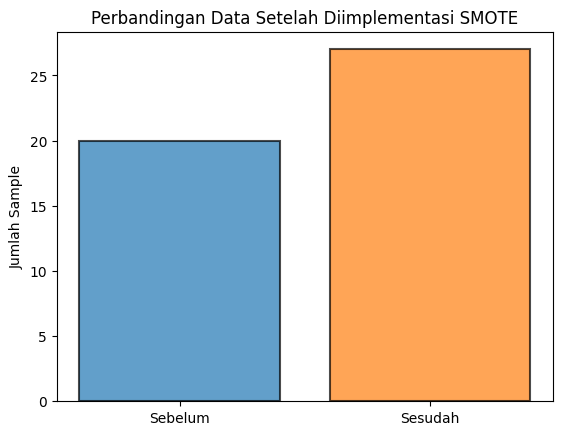

In [239]:
import matplotlib.pyplot as plt

plt.bar('Sebelum', len(stack_majority) + len(stack_minority), alpha=0.7, edgecolor='black', linewidth=1.5)
plt.bar('Sesudah', len(final_stack), alpha=0.7, edgecolor='black', linewidth=1.5)

plt.ylabel('Jumlah Sample')
plt.title('Perbandingan Data Setelah Diimplementasi SMOTE')

plt.show()

In [71]:
# X_embedding = np.array(df_ready['embedding'][:2]).reshape(-1, 1)
# sentiment_values = np.array(df_ready['Sentimen_Text'][:2]).reshape(-1, 1)

# num_rows = X_embedding.shape[0]

# X_sentiment = np.empty((num_rows, 1), dtype=np.str_)

# for i in range(num_rows):
#     X_sentiment[i] = sentiment_values[i % sentiment_values.shape[0]]

# X = np.hstack((X_embedding, X_sentiment))

# X

In [72]:
# y = df_ready['Sarcasm']

# y

In [73]:
# from sklearn.neighbors import NearestNeighbors

# def get_k_nearest_neighbors(X, sample, k):
#     # Mencari tetangga terdekat menggunakan k-NN
#     knn = NearestNeighbors(n_neighbors=k+1)
#     knn.fit(X)
    
#     # Mengembalikan indeks tetangga terdekat untuk sampel
#     _, indices = knn.kneighbors([sample])
#     indices_1d = indices.flatten()  # Mengubah menjadi 1D array
    
#     return indices_1d[1:]  # Menghilangkan indeks diri sendiri

In [74]:
# import pandas as pd
# import numpy as np
# import math

# def SMOTE(df, k, oversampling_ratio):
#     # Mendapatkan array numpy dari fitur embedding, sentiment, dan label
#     embeddings = np.vstack(df['embedding'].to_numpy())
#     labels = df['Sarcasm'].to_numpy()
    
#     # Menginisialisasi array untuk menyimpan sampel sintetis yang dihasilkan
#     synthetic_samples = []
    
#     # Mencari indeks sampel minoritas dan mayoritas
#     minority_indices = np.where(labels == 1)[0]
#     majority_indices = np.where(labels == 0)[0]
    
#     # Menghitung jumlah sampel sintetis yang akan dibuat untuk kelas minoritas
#     num_minority_samples = len(minority_indices)
#     num_majority_samples = len(majority_indices)
    
#     num_synthetic_samples = min(num_majority_samples - num_minority_samples, math.ceil(num_minority_samples * oversampling_ratio))
    
#     if num_synthetic_samples <= 0:
#         return pd.DataFrame()  # Return empty DataFrame jika tidak ada sampel sintetis yang perlu dibuat
    
#     # Looping melalui setiap sampel minoritas
#     for i in minority_indices:
#         sample = embeddings[i]
        
#         # Mencari tetangga terdekat untuk sampel minoritas
#         neighbors = get_k_nearest_neighbors(embeddings, sample, k)
        
#         # Menghasilkan sampel sintetis
#         for j in range(num_synthetic_samples):
#             # Memilih satu tetangga acak
#             neighbor_index = np.random.choice(neighbors)
            
#             if neighbor_index >= len(embeddings):
#                 continue  # Skip jika indeks tetangga melebihi ukuran data yang valid
            
#             neighbor = embeddings[neighbor_index]
            
#             # Menghitung selisih antara sampel dan tetangga
#             diff = neighbor - sample
            
#             # Menghasilkan sampel sintetis dengan proporsi acak
#             proportion = np.random.uniform(0, 1, size=1)
#             synthetic_sample = sample + proportion * diff
            
#             # Menambahkan sampel sintetis ke array
#             synthetic_samples.append(synthetic_sample)
    
#     # Mengubah array numpy ke DataFrame
#     embedding_array = np.vstack(synthetic_samples)
#     embedding_df = pd.DataFrame(embedding_array, columns=['embedding'] * embedding_array.shape[1])
#     sarcasm_df = pd.DataFrame(np.zeros((embedding_array.shape[0], 1)), columns=['Sarcasm'])
#     synthetic_df = pd.concat([embedding_df, sarcasm_df], axis=1)
    
#     # Menambahkan label kelas minoritas pada data sintetis
#     synthetic_df['Sarcasm'] = 1

#     return synthetic_df

In [75]:
# oversampled_df = SMOTE(df_ready, k=5, oversampling_ratio=1.0)

<h1>Training Bi-LSTM<h1>

<h2>Fungsi untuk merubah word embedding menjadi token</h2>

In [76]:
# def replace_embedding_with_token(embeddings, word_embedding):
#     token = []
#     for value in embeddings:
#         index = np.array(value)
#         vector = tuple(index) 
#         if vector in word_embedding:
#             token.append(word_embedding[vector])
    
#     return token

In [77]:
# df_ready['text_emoji'] = df_ready['text_emoji'].apply(replace_embedding_with_token, word_embedding=embedding2word)

In [78]:
# df_ready['text_emoji'] = df_ready['text_emoji'].apply(lambda x: ' '.join(x))

In [79]:
# df_ready.head(11)